<a href="https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_cellpose_2_sparse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running cellpose 2.0 with sparse annotations

<font size = 4>Cellpose 2.0 extension for training with sparse annotations.

This notebook shows how to train cellpose models with sparse annotations.

# Setup

We expect that you already set up a conda environment.\
The following command will install the extra modules required in this notebook.

In [13]:
!pip install --no-deps stardist==0.8.3 csbdeep==0.7.2

Check CUDA version and that GPU is working in cellpose and import other libraries.

In [1]:
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics, transforms
from csbdeep.utils import Path, download_and_extract_zip_file, normalize
from glob import glob
from natsort import natsorted
from stardist import fill_label_holes, random_label_cmap
from stardist.matching import matching, matching_dataset
import skimage.measure
from tifffile import imread
from tqdm import tqdm


from utils import plot_img_label, to_sparse, get_data, plot_stats, run_analysis, remove_small_labels

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

/bin/bash: nvcc: command not found
Sun Sep 25 23:34:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:17:00.0 Off |                  Off |
| 30%   40C    P8    30W / 300W |      5MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    Off  | 00000000:73:00.0 Of

# Data

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [2]:
(X_trn, Y_trn), (X_val, Y_val) = get_data()

Files found, nothing to download.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 123.91it/s]

number of images for training:   416
number of images for validation:  48


# Train model on manual annotations

Skip this step if you already have a pretrained model.

Fill out the form below with the paths to your data and the parameters to start training.

## Training parameters

<font size = 4> **Paths for training, predictions and results**


<font size = 4>**`train_dir:`, `test_dir`:** These are the paths to your folders train_dir (with images and masks of training images) and test_dir (with images and masks of test images). You can leave the test_dir blank, but it's recommended to have some test images to check the model's performance. To find the paths of the folders containing the respective datasets, go to your Files on the left of the notebook, navigate to the folder containing your files and copy the path by right-clicking on the folder, **Copy path** and pasting it into the right box below.

<font size = 4>**`initial_model`:** Choose a model from the cellpose [model zoo](https://cellpose.readthedocs.io/en/latest/models.html#model-zoo) to start from.

<font size = 4>**`model_name`**: Enter the path where your model will be saved once trained (for instance your result folder).

<font size = 4>**Training parameters**

<font size = 4>**`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. At least 100 epochs are recommended, but sometimes 250 epochs are necessary, particularly from scratch. **Default value: 100**



In [3]:
#@markdown ###Path to saved models:

save_path = "." #@param {type:"string"}

# model name and path
#@markdown ###Name of the pretrained model to start from and new model name:
initial_model = "scratch" #@param ['cyto','nuclei','tissuenet','livecell','cyto2','CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4','scratch']

# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
n_epochs =  100 #@param {type:"number"}

Channel_to_use_for_training = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you have a secondary channel that can be used for training, for instance nuclei, choose it here:

Second_training_channel= "None" #@param ["None", "Blue", "Green", "Red"]


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = False #@param {type:"boolean"}
#@markdown ###If not, please input:
learning_rate = 0.001 #@param {type:"number"}
weight_decay = 0.0001 #@param {type:"number"}

# Here we match the channel to number
chan = ["Grayscale", "Red", "Green", "Blue"].index(Channel_to_use_for_training)
chan2 = ["None", "Red", "Green", "Blue"].index(Second_training_channel)

if initial_model=='scratch':
    initial_model = None

## Train new model

Using settings from form above, train model in notebook.

In [4]:
def train_model(X_trn, Y_trn, X_val, Y_val, description, **kwargs):
    use_GPU = kwargs.get('use_GPU', core.use_gpu())
    initial_model = kwargs.get('initial_model', None)
    channels = kwargs.get('channels', [0, 0])
    save_path = kwargs.get('save_path', '.')
    n_epochs = kwargs.get('n_epochs', 100)
    learning_rate = kwargs.get('learning_rate', 0.001)
    weight_decay = kwargs.get('weight_decay', 0.0001)
    nimg_per_epoch = kwargs.get('nimg_per_epoch', 8)
    
    model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)
    model.train(X_trn.copy(),
                Y_trn,
                test_data=X_val.copy(),
                test_labels=Y_val.copy(),
                channels=channels,
                normalize=False, # already normalized
                save_path=save_path,
                n_epochs=n_epochs,
                learning_rate=learning_rate,
                weight_decay=weight_decay,
                nimg_per_epoch=nimg_per_epoch,
                model_name=description,
                min_train_masks=1)

In [5]:
def eval_model(X_val, description, **kwargs):
    use_GPU = kwargs.get('use_GPU', core.use_gpu())
    save_path = kwargs.get('save_path', '.')
    model_path = os.path.join(save_path, 'models', description)
    model = models.CellposeModel(gpu=use_GPU, pretrained_model=model_path)
    channels = kwargs.get('channels', [0, 0])       
    diam_labels = model.diam_labels.copy()
    return [model.eval(x,
                       channels=channels,
                       normalize=False, # already normalized
                       diameter=diam_labels)[0]
            for x in tqdm(X_val)]

In [6]:
# start logger (to see training across epochs)
logger = io.logger_setup()

2022-09-25 23:43:10,207 [INFO] WRITING LOG OUTPUT TO /home/useradmin/.cellpose/run.log


In [7]:
is_train = input('Train models? (existing models can be overwritten) (y/n): ').lower().strip() == 'y'

Train models? (existing models can be overwritten) (y/n): y


416it [00:05, 81.18it/s] 


2022-09-29 12:06:49,125 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 12:06:49,127 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 12:06:49,128 [INFO] >>>> using GPU
2022-09-29 12:06:49,373 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:04<00:00, 93.52it/s]


2022-09-29 12:06:54,898 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.96it/s]


2022-09-29 12:06:57,126 [INFO] >>>> median diameter set to = 30
2022-09-29 12:06:57,128 [INFO] >>>> mean of training label mask diameters (saved to model) 14.897
2022-09-29 12:06:57,129 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 12:06:57,130 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 12:06:57,131 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 12:06:57,133 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 12:07:05,237 [INFO] Epoch 0, Time  8.1s, Loss 2.1501, Loss Test 1.5788, LR 0.0000
2022-09-29 12:07:13,027 [INFO] saving network parameters to paper03/models/min_001
2022-09-29 12:07:46,773 [INFO] Epoch 5, Time 49.6s, Loss 1.1161, Loss Test 1.1538, LR 0.0006
2022-09-29 12:08:28,938 [INFO] Epoch 10, Time 91.8s, Loss 0.7251, Loss Test 0.9274, LR 0.0010
2022-09-29 12:09:54,560 [INFO] Epoch 20, Time 177.4s, Loss 0.5123, Loss Test 1.2449, LR 0.0010
2022-09-29 12:11:19,926 [INFO] Epoch 30, Time 262.8s, Loss 0.3384, Loss Test 1.4229, LR 0.0010
20

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.82it/s]


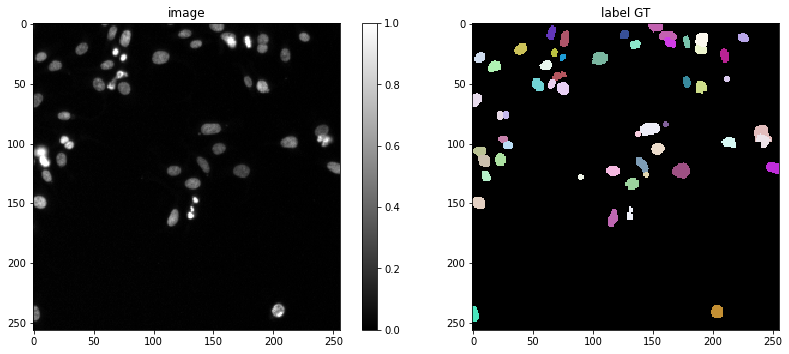

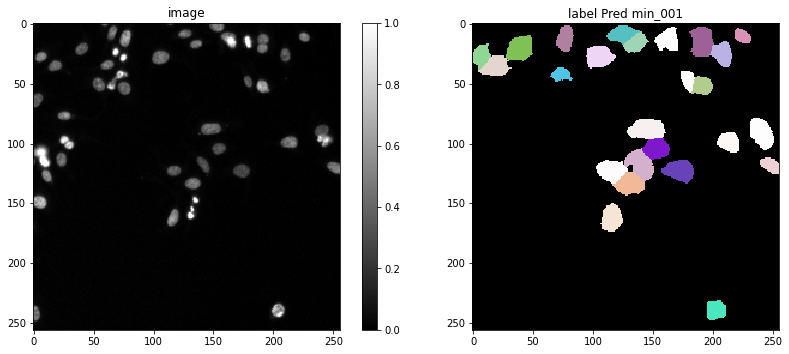

416it [00:04, 94.42it/s] 

2022-09-29 12:21:24,217 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 12:21:24,218 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 12:21:24,219 [INFO] >>>> using GPU


2022-09-29 12:21:24,479 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:06<00:00, 60.21it/s]


2022-09-29 12:21:32,473 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.50it/s]


2022-09-29 12:21:34,768 [INFO] >>>> median diameter set to = 30
2022-09-29 12:21:34,770 [INFO] >>>> mean of training label mask diameters (saved to model) 19.793
2022-09-29 12:21:34,771 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 12:21:34,772 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 12:21:34,773 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 12:21:34,774 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 12:21:43,588 [INFO] Epoch 0, Time  8.8s, Loss 3.5537, Loss Test 1.5258, LR 0.0000
2022-09-29 12:21:52,050 [INFO] saving network parameters to paper03/models/min_004
2022-09-29 12:22:26,659 [INFO] Epoch 5, Time 51.9s, Loss 1.3949, Loss Test 0.8328, LR 0.0006
2022-09-29 12:23:09,819 [INFO] Epoch 10, Time 95.0s, Loss 0.7530, Loss Test 0.9395, LR 0.0010
2022-09-29 12:24:36,149 [INFO] Epoch 20, Time 181.4s, Loss 0.6021, Loss Test 1.0603, LR 0.0010
2022-09-29 12:26:02,169 [INFO] Epoch 30, Time 267.4s, Loss 0.5134, Loss Test 1.3138, LR 0.0010
20

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.42it/s]


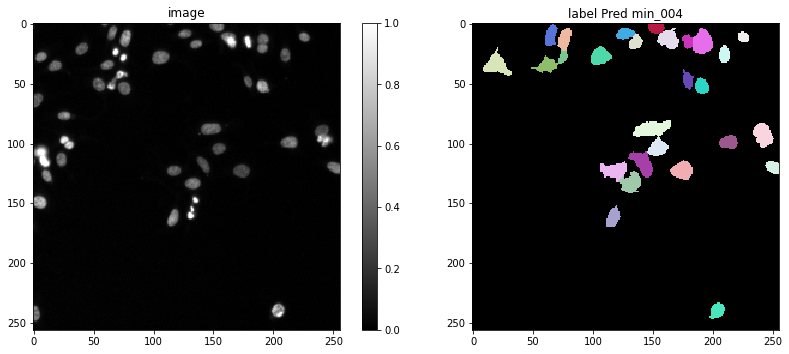

416it [00:04, 94.56it/s] 

2022-09-29 12:36:12,897 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 12:36:12,898 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 12:36:12,899 [INFO] >>>> using GPU


2022-09-29 12:36:13,156 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:08<00:00, 46.59it/s]


2022-09-29 12:36:23,171 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.76it/s]


2022-09-29 12:36:25,441 [INFO] >>>> median diameter set to = 30
2022-09-29 12:36:25,442 [INFO] >>>> mean of training label mask diameters (saved to model) 22.620
2022-09-29 12:36:25,444 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 12:36:25,444 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 12:36:25,445 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 12:36:25,446 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 12:36:34,733 [INFO] Epoch 0, Time  9.3s, Loss 4.3563, Loss Test 1.5368, LR 0.0000
2022-09-29 12:36:43,521 [INFO] saving network parameters to paper03/models/min_016
2022-09-29 12:37:19,180 [INFO] Epoch 5, Time 53.7s, Loss 1.4981, Loss Test 1.0680, LR 0.0006
2022-09-29 12:38:03,013 [INFO] Epoch 10, Time 97.6s, Loss 0.6993, Loss Test 1.1293, LR 0.0010
2022-09-29 12:39:30,713 [INFO] Epoch 20, Time 185.3s, Loss 0.5930, Loss Test 1.2894, LR 0.0010
2022-09-29 12:40:57,711 [INFO] Epoch 30, Time 272.3s, Loss 0.5287, Loss Test 1.4543, LR 0.0010
20

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.65it/s]


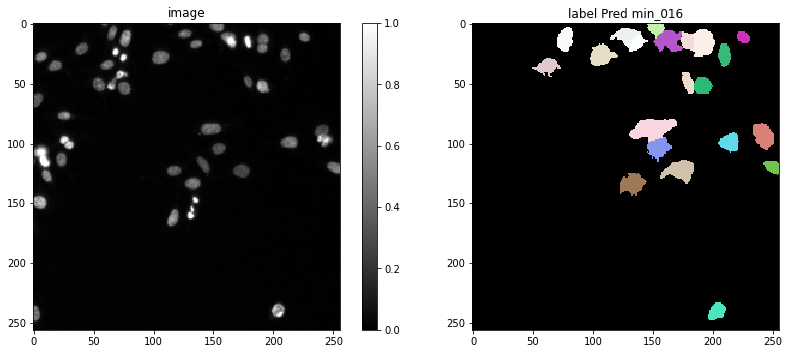

416it [00:04, 86.05it/s] 

2022-09-29 12:51:21,256 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 12:51:21,258 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 12:51:21,260 [INFO] >>>> using GPU


2022-09-29 12:51:21,527 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:09<00:00, 45.43it/s]


2022-09-29 12:51:31,801 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.24it/s]


2022-09-29 12:51:34,118 [INFO] >>>> median diameter set to = 30
2022-09-29 12:51:34,120 [INFO] >>>> mean of training label mask diameters (saved to model) 22.575
2022-09-29 12:51:34,122 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 12:51:34,122 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 12:51:34,123 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 12:51:34,124 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 12:51:43,199 [INFO] Epoch 0, Time  9.1s, Loss 4.5239, Loss Test 1.7052, LR 0.0000
2022-09-29 12:51:52,054 [INFO] saving network parameters to paper03/models/min_064
2022-09-29 12:52:27,923 [INFO] Epoch 5, Time 53.8s, Loss 1.4648, Loss Test 0.9996, LR 0.0006
2022-09-29 12:53:12,160 [INFO] Epoch 10, Time 98.0s, Loss 0.7229, Loss Test 1.1101, LR 0.0010
2022-09-29 12:54:40,028 [INFO] Epoch 20, Time 185.9s, Loss 0.5970, Loss Test 1.3811, LR 0.0010
2022-09-29 12:56:05,184 [INFO] Epoch 30, Time 271.1s, Loss 0.5334, Loss Test 1.4912, LR 0.0010
20

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.10it/s]


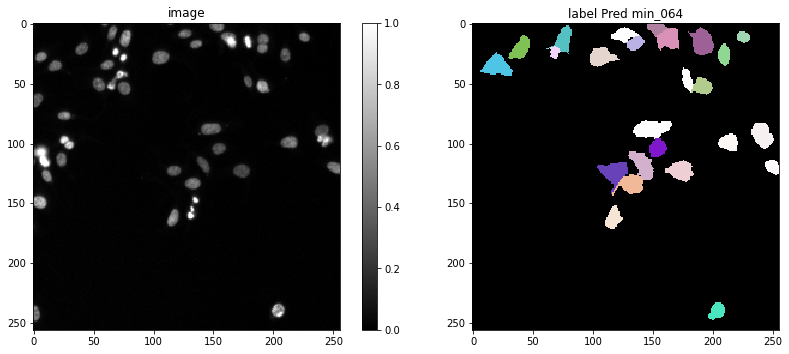

416it [00:05, 82.31it/s] 

2022-09-29 13:06:29,514 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 13:06:29,516 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 13:06:29,516 [INFO] >>>> using GPU


2022-09-29 13:06:29,780 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:10<00:00, 37.95it/s]


2022-09-29 13:06:42,324 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 28.46it/s]


2022-09-29 13:06:44,975 [INFO] >>>> median diameter set to = 30
2022-09-29 13:06:44,977 [INFO] >>>> mean of training label mask diameters (saved to model) 22.573
2022-09-29 13:06:44,978 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 13:06:44,979 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 13:06:44,980 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 13:06:44,981 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 13:06:54,172 [INFO] Epoch 0, Time  9.2s, Loss 4.6021, Loss Test 1.5560, LR 0.0000
2022-09-29 13:07:03,038 [INFO] saving network parameters to paper03/models/min_256
2022-09-29 13:07:39,186 [INFO] Epoch 5, Time 54.2s, Loss 1.5320, Loss Test 0.9388, LR 0.0006
2022-09-29 13:08:22,743 [INFO] Epoch 10, Time 97.8s, Loss 0.7514, Loss Test 1.0358, LR 0.0010
2022-09-29 13:09:49,682 [INFO] Epoch 20, Time 184.7s, Loss 0.5997, Loss Test 1.2447, LR 0.0010
2022-09-29 13:11:16,626 [INFO] Epoch 30, Time 271.6s, Loss 0.5323, Loss Test 1.4333, LR 0.0010
20

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.90it/s]


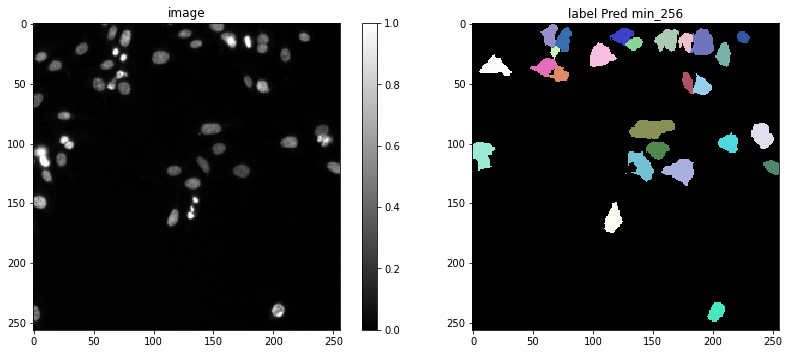

2022-09-29 13:21:30,410 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 13:21:30,412 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 13:21:30,413 [INFO] >>>> using GPU
2022-09-29 13:21:30,717 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:11<00:00, 35.26it/s]


2022-09-29 13:21:43,120 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.08it/s]


2022-09-29 13:21:45,473 [INFO] >>>> median diameter set to = 30
2022-09-29 13:21:45,476 [INFO] >>>> mean of training label mask diameters (saved to model) 23.259
2022-09-29 13:21:45,478 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 13:21:45,479 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 13:21:45,479 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 13:21:45,480 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 13:21:56,049 [INFO] Epoch 0, Time 10.6s, Loss 1.4308, Loss Test 1.4409, LR 0.0000
2022-09-29 13:22:05,969 [INFO] saving network parameters to paper03/models/min_full
2022-09-29 13:22:46,691 [INFO] Epoch 5, Time 61.2s, Loss 0.8418, Loss Test 0.5146, LR 0.0006
2022-09-29 13:23:36,925 [INFO] Epoch 10, Time 111.4s, Loss 0.4029, Loss Test 0.3008, LR 0.0010
2022-09-29 13:25:18,376 [INFO] Epoch 20, Time 212.9s, Loss 0.2666, Loss Test 0.2175, LR 0.0010
2022-09-29 13:26:58,455 [INFO] Epoch 30, Time 313.0s, Loss 0.2252, Loss Test 0.1979, LR 0.0010


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  5.18it/s]


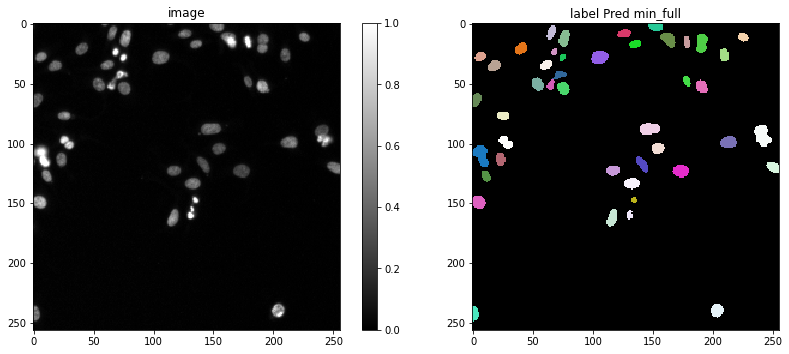

416it [00:03, 109.68it/s]


2022-09-29 13:38:31,922 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 13:38:31,924 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 13:38:31,925 [INFO] >>>> using GPU
2022-09-29 13:38:32,163 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:05<00:00, 79.24it/s]


2022-09-29 13:38:38,467 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 36.35it/s]


2022-09-29 13:38:40,615 [INFO] >>>> median diameter set to = 30
2022-09-29 13:38:40,616 [INFO] >>>> mean of training label mask diameters (saved to model) 21.360
2022-09-29 13:38:40,617 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 13:38:40,618 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 13:38:40,619 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 13:38:40,620 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 13:38:48,496 [INFO] Epoch 0, Time  7.9s, Loss 2.1658, Loss Test 1.5864, LR 0.0000
2022-09-29 13:38:56,815 [INFO] saving network parameters to paper03/models/max_001
2022-09-29 13:39:31,382 [INFO] Epoch 5, Time 50.8s, Loss 0.6644, Loss Test 1.0885, LR 0.0006
2022-09-29 13:40:14,531 [INFO] Epoch 10, Time 93.9s, Loss 0.4139, Loss Test 1.0293, LR 0.0010
2022-09-29 13:41:41,096 [INFO] Epoch 20, Time 180.5s, Loss 0.2908, Loss Test 1.0093, LR 0.0010
2022-09-29 13:43:06,539 [INFO] Epoch 30, Time 265.9s, Loss 0.2631, Loss Test 0.8820, LR 0.0010
20

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.42it/s]


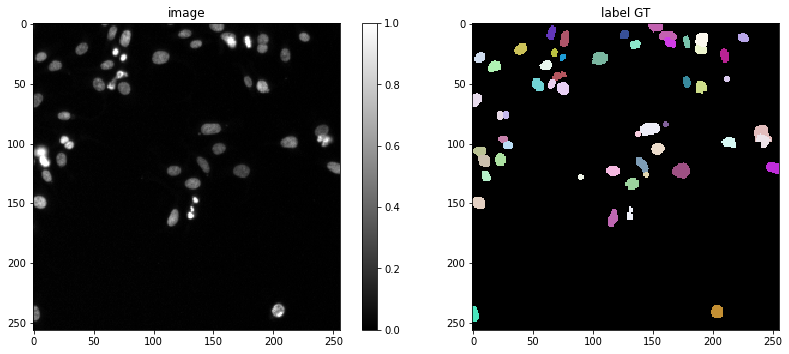

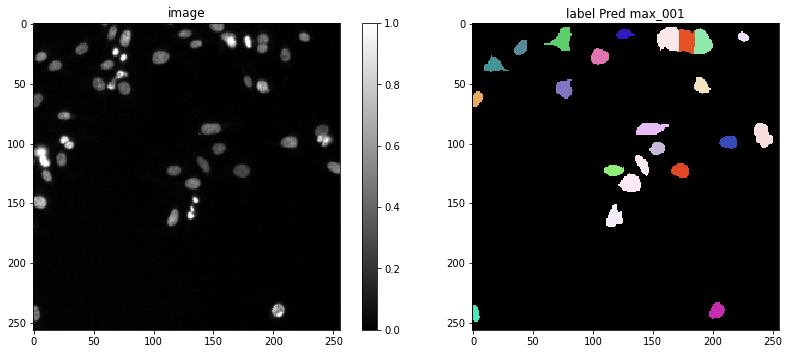

416it [00:05, 74.89it/s]


2022-09-29 13:53:27,483 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 13:53:27,486 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 13:53:27,487 [INFO] >>>> using GPU
2022-09-29 13:53:27,877 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:09<00:00, 42.35it/s]


2022-09-29 13:53:39,010 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 30.93it/s]


2022-09-29 13:53:41,506 [INFO] >>>> median diameter set to = 30
2022-09-29 13:53:41,507 [INFO] >>>> mean of training label mask diameters (saved to model) 22.236
2022-09-29 13:53:41,509 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 13:53:41,509 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 13:53:41,510 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 13:53:41,511 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 13:53:50,766 [INFO] Epoch 0, Time  9.3s, Loss 3.7459, Loss Test 1.5221, LR 0.0000
2022-09-29 13:53:59,499 [INFO] saving network parameters to paper03/models/max_004
2022-09-29 13:54:35,467 [INFO] Epoch 5, Time 54.0s, Loss 1.0352, Loss Test 0.9741, LR 0.0006
2022-09-29 13:55:20,187 [INFO] Epoch 10, Time 98.7s, Loss 0.5674, Loss Test 0.8955, LR 0.0010
2022-09-29 13:56:49,182 [INFO] Epoch 20, Time 187.7s, Loss 0.4279, Loss Test 0.9911, LR 0.0010
2022-09-29 13:58:18,651 [INFO] Epoch 30, Time 277.1s, Loss 0.3399, Loss Test 1.1450, LR 0.0010
20

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.55it/s]


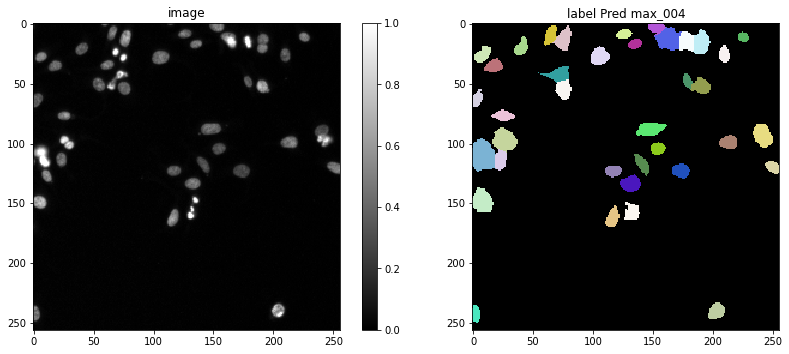

416it [00:04, 86.82it/s] 

2022-09-29 14:08:46,136 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 14:08:46,138 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 14:08:46,139 [INFO] >>>> using GPU


2022-09-29 14:08:46,415 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:08<00:00, 46.67it/s]


2022-09-29 14:08:56,492 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 31.68it/s]


2022-09-29 14:08:58,952 [INFO] >>>> median diameter set to = 30
2022-09-29 14:08:58,954 [INFO] >>>> mean of training label mask diameters (saved to model) 23.018
2022-09-29 14:08:58,956 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 14:08:58,956 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 14:08:58,957 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 14:08:58,958 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 14:09:08,300 [INFO] Epoch 0, Time  9.3s, Loss 5.3110, Loss Test 1.6297, LR 0.0000
2022-09-29 14:09:17,304 [INFO] saving network parameters to paper03/models/max_016
2022-09-29 14:09:54,473 [INFO] Epoch 5, Time 55.5s, Loss 1.3694, Loss Test 0.9571, LR 0.0006
2022-09-29 14:10:39,947 [INFO] Epoch 10, Time 101.0s, Loss 0.6693, Loss Test 1.1786, LR 0.0010
2022-09-29 14:12:10,593 [INFO] Epoch 20, Time 191.6s, Loss 0.5154, Loss Test 1.1402, LR 0.0010
2022-09-29 14:13:41,144 [INFO] Epoch 30, Time 282.2s, Loss 0.4439, Loss Test 1.3649, LR 0.0010
2

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.22it/s]


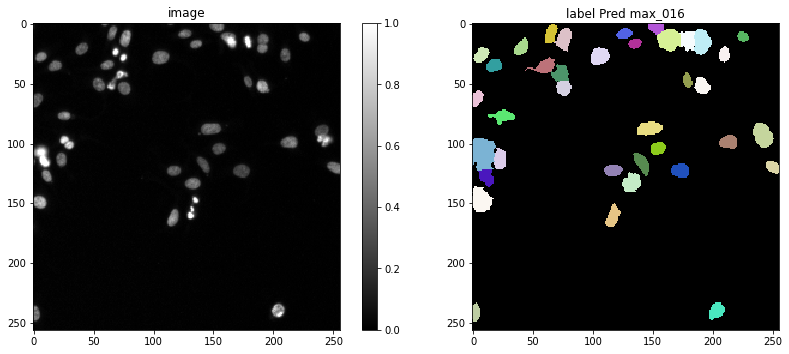

416it [00:05, 78.88it/s] 


2022-09-29 14:24:26,311 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 14:24:26,313 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 14:24:26,314 [INFO] >>>> using GPU
2022-09-29 14:24:26,718 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:10<00:00, 38.51it/s]


2022-09-29 14:24:38,782 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 24.09it/s]


2022-09-29 14:24:42,225 [INFO] >>>> median diameter set to = 30
2022-09-29 14:24:42,226 [INFO] >>>> mean of training label mask diameters (saved to model) 23.041
2022-09-29 14:24:42,228 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 14:24:42,229 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 14:24:42,230 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 14:24:42,232 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 14:24:51,872 [INFO] Epoch 0, Time  9.6s, Loss 4.9797, Loss Test 1.6190, LR 0.0000
2022-09-29 14:25:00,991 [INFO] saving network parameters to paper03/models/max_064
2022-09-29 14:25:38,141 [INFO] Epoch 5, Time 55.9s, Loss 1.2628, Loss Test 0.9329, LR 0.0006
2022-09-29 14:26:23,672 [INFO] Epoch 10, Time 101.4s, Loss 0.6745, Loss Test 1.2094, LR 0.0010
2022-09-29 14:27:55,071 [INFO] Epoch 20, Time 192.8s, Loss 0.5277, Loss Test 1.1275, LR 0.0010
2022-09-29 14:29:25,586 [INFO] Epoch 30, Time 283.4s, Loss 0.4586, Loss Test 1.3808, LR 0.0010
2

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.34it/s]


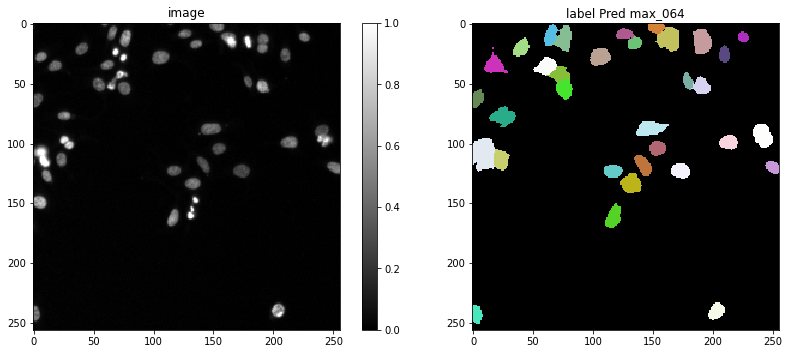

416it [00:05, 82.15it/s]

2022-09-29 14:40:12,889 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 14:40:12,890 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 14:40:12,891 [INFO] >>>> using GPU


2022-09-29 14:40:13,183 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:10<00:00, 39.35it/s]


2022-09-29 14:40:25,203 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 31.25it/s]


2022-09-29 14:40:27,730 [INFO] >>>> median diameter set to = 30
2022-09-29 14:40:27,731 [INFO] >>>> mean of training label mask diameters (saved to model) 23.044
2022-09-29 14:40:27,733 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 14:40:27,734 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 14:40:27,735 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 14:40:27,736 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 14:40:36,926 [INFO] Epoch 0, Time  9.2s, Loss 4.5954, Loss Test 1.6793, LR 0.0000
2022-09-29 14:40:45,850 [INFO] saving network parameters to paper03/models/max_256
2022-09-29 14:41:22,878 [INFO] Epoch 5, Time 55.1s, Loss 1.3086, Loss Test 0.9462, LR 0.0006
2022-09-29 14:42:08,744 [INFO] Epoch 10, Time 101.0s, Loss 0.6877, Loss Test 1.0936, LR 0.0010
2022-09-29 14:43:38,980 [INFO] Epoch 20, Time 191.2s, Loss 0.5318, Loss Test 1.1944, LR 0.0010
2022-09-29 14:45:10,533 [INFO] Epoch 30, Time 282.8s, Loss 0.4546, Loss Test 1.3697, LR 0.0010
2

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.09it/s]


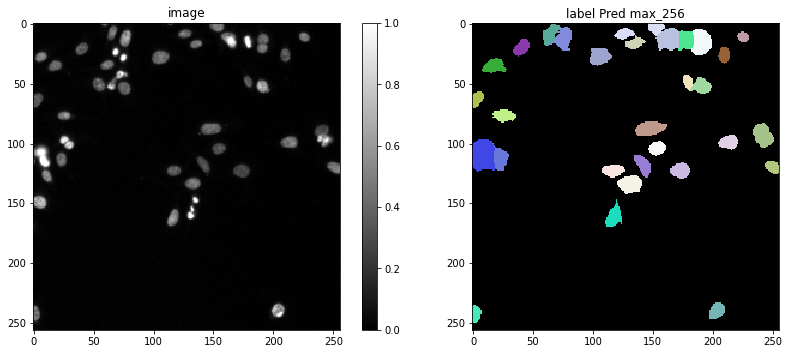

2022-09-29 14:55:49,637 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 14:55:49,639 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 14:55:49,640 [INFO] >>>> using GPU
2022-09-29 14:55:49,959 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:12<00:00, 33.45it/s]


2022-09-29 14:56:03,023 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 31.37it/s]


2022-09-29 14:56:05,576 [INFO] >>>> median diameter set to = 30
2022-09-29 14:56:05,577 [INFO] >>>> mean of training label mask diameters (saved to model) 23.259
2022-09-29 14:56:05,579 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 14:56:05,580 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 14:56:05,581 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 14:56:05,582 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 14:56:16,067 [INFO] Epoch 0, Time 10.5s, Loss 1.5340, Loss Test 1.5156, LR 0.0000
2022-09-29 14:56:26,766 [INFO] saving network parameters to paper03/models/max_full
2022-09-29 14:57:08,020 [INFO] Epoch 5, Time 62.4s, Loss 0.8393, Loss Test 0.4983, LR 0.0006
2022-09-29 14:57:59,629 [INFO] Epoch 10, Time 114.0s, Loss 0.3837, Loss Test 0.2796, LR 0.0010
2022-09-29 14:59:41,444 [INFO] Epoch 20, Time 215.9s, Loss 0.2617, Loss Test 0.2162, LR 0.0010
2022-09-29 15:01:23,155 [INFO] Epoch 30, Time 317.6s, Loss 0.2234, Loss Test 0.1993, LR 0.0010


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.50it/s]


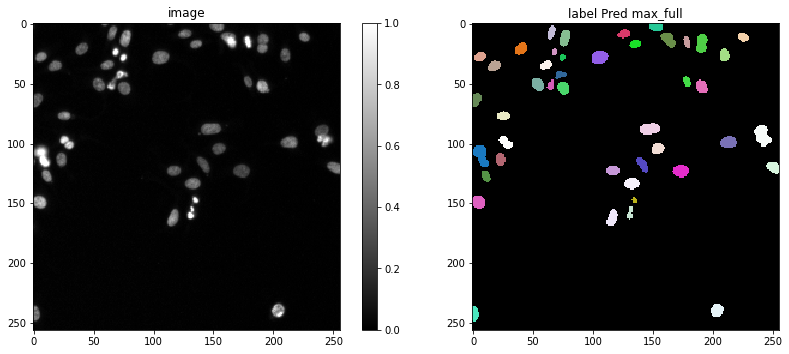

416it [00:05, 80.50it/s] 


2022-09-29 15:13:07,679 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 15:13:07,680 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 15:13:07,681 [INFO] >>>> using GPU
2022-09-29 15:13:07,928 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:05<00:00, 79.57it/s]


2022-09-29 15:13:14,246 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.37it/s]


2022-09-29 15:13:16,497 [INFO] >>>> median diameter set to = 30
2022-09-29 15:13:16,499 [INFO] >>>> mean of training label mask diameters (saved to model) 17.034
2022-09-29 15:13:16,501 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 15:13:16,502 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 15:13:16,503 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 15:13:16,504 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 15:13:25,545 [INFO] Epoch 0, Time  9.0s, Loss 2.5852, Loss Test 1.6508, LR 0.0000
2022-09-29 15:13:33,895 [INFO] saving network parameters to paper03/models/minmax_001
2022-09-29 15:14:08,283 [INFO] Epoch 5, Time 51.8s, Loss 1.0736, Loss Test 1.4519, LR 0.0006
2022-09-29 15:14:51,624 [INFO] Epoch 10, Time 95.1s, Loss 0.7917, Loss Test 1.1411, LR 0.0010
2022-09-29 15:16:17,579 [INFO] Epoch 20, Time 181.1s, Loss 0.6135, Loss Test 1.1365, LR 0.0010
2022-09-29 15:17:44,520 [INFO] Epoch 30, Time 268.0s, Loss 0.4556, Loss Test 1.1963, LR 0.0010

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.87it/s]


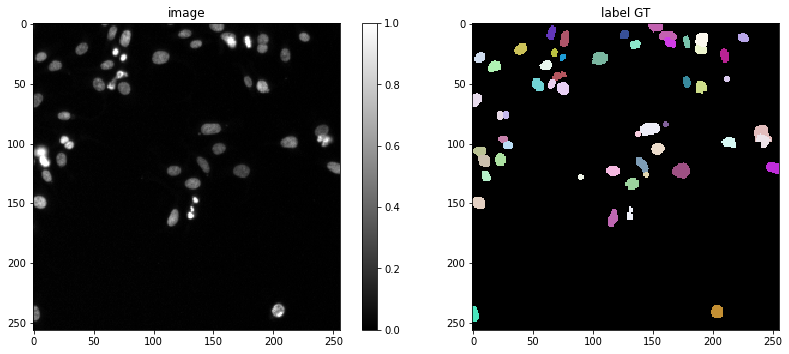

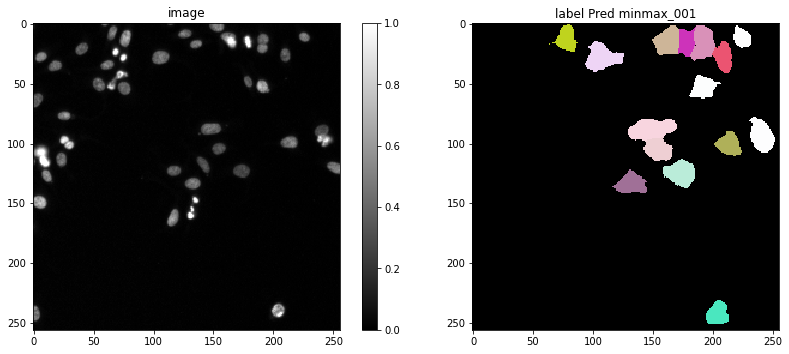

416it [00:04, 84.94it/s] 

2022-09-29 15:28:02,463 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 15:28:02,464 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 15:28:02,465 [INFO] >>>> using GPU


2022-09-29 15:28:02,730 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:07<00:00, 57.40it/s]


2022-09-29 15:28:11,108 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.11it/s]


2022-09-29 15:28:13,496 [INFO] >>>> median diameter set to = 30
2022-09-29 15:28:13,498 [INFO] >>>> mean of training label mask diameters (saved to model) 19.633
2022-09-29 15:28:13,499 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 15:28:13,500 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 15:28:13,500 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 15:28:13,501 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 15:28:22,686 [INFO] Epoch 0, Time  9.2s, Loss 3.8024, Loss Test 1.5316, LR 0.0000
2022-09-29 15:28:31,449 [INFO] saving network parameters to paper03/models/minmax_004
2022-09-29 15:29:06,613 [INFO] Epoch 5, Time 53.1s, Loss 1.3147, Loss Test 0.9537, LR 0.0006
2022-09-29 15:29:50,597 [INFO] Epoch 10, Time 97.1s, Loss 0.7513, Loss Test 1.0266, LR 0.0010
2022-09-29 15:31:17,118 [INFO] Epoch 20, Time 183.6s, Loss 0.5350, Loss Test 1.3053, LR 0.0010
2022-09-29 15:32:42,100 [INFO] Epoch 30, Time 268.6s, Loss 0.4687, Loss Test 1.3820, LR 0.0010

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.14it/s]


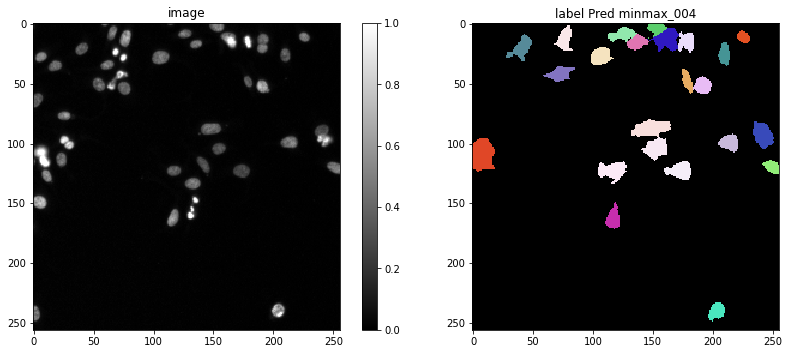

416it [00:04, 85.26it/s]


2022-09-29 15:43:11,195 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 15:43:11,197 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 15:43:11,198 [INFO] >>>> using GPU
2022-09-29 15:43:11,465 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:11<00:00, 36.73it/s]


2022-09-29 15:43:24,356 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 25.40it/s]


2022-09-29 15:43:27,679 [INFO] >>>> median diameter set to = 30
2022-09-29 15:43:27,682 [INFO] >>>> mean of training label mask diameters (saved to model) 22.935
2022-09-29 15:43:27,684 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 15:43:27,685 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 15:43:27,686 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 15:43:27,687 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 15:43:37,330 [INFO] Epoch 0, Time  9.6s, Loss 5.4734, Loss Test 1.5286, LR 0.0000
2022-09-29 15:43:46,476 [INFO] saving network parameters to paper03/models/minmax_016
2022-09-29 15:44:23,430 [INFO] Epoch 5, Time 55.7s, Loss 1.5159, Loss Test 0.8772, LR 0.0006
2022-09-29 15:45:09,630 [INFO] Epoch 10, Time 101.9s, Loss 0.7239, Loss Test 0.9959, LR 0.0010
2022-09-29 15:46:40,180 [INFO] Epoch 20, Time 192.5s, Loss 0.5645, Loss Test 1.1843, LR 0.0010
2022-09-29 15:48:10,352 [INFO] Epoch 30, Time 282.7s, Loss 0.4933, Loss Test 1.5058, LR 0.001

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.25it/s]


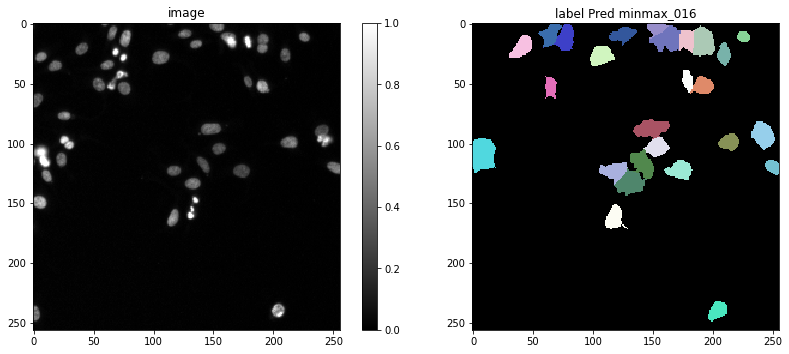

416it [00:05, 82.92it/s]

2022-09-29 15:58:50,695 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 15:58:50,697 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 15:58:50,698 [INFO] >>>> using GPU


2022-09-29 15:58:51,082 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:15<00:00, 27.12it/s]


2022-09-29 15:59:07,708 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.10it/s]


2022-09-29 15:59:10,197 [INFO] >>>> median diameter set to = 30
2022-09-29 15:59:10,198 [INFO] >>>> mean of training label mask diameters (saved to model) 23.283
2022-09-29 15:59:10,199 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 15:59:10,200 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 15:59:10,201 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 15:59:10,202 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 15:59:19,653 [INFO] Epoch 0, Time  9.5s, Loss 5.3858, Loss Test 1.4461, LR 0.0000
2022-09-29 15:59:28,842 [INFO] saving network parameters to paper03/models/minmax_064
2022-09-29 16:00:05,946 [INFO] Epoch 5, Time 55.7s, Loss 1.4789, Loss Test 0.8678, LR 0.0006
2022-09-29 16:00:52,597 [INFO] Epoch 10, Time 102.4s, Loss 0.7346, Loss Test 1.0292, LR 0.0010
2022-09-29 16:02:23,104 [INFO] Epoch 20, Time 192.9s, Loss 0.5747, Loss Test 1.2939, LR 0.0010
2022-09-29 16:03:53,871 [INFO] Epoch 30, Time 283.7s, Loss 0.5088, Loss Test 1.4952, LR 0.001

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.34it/s]


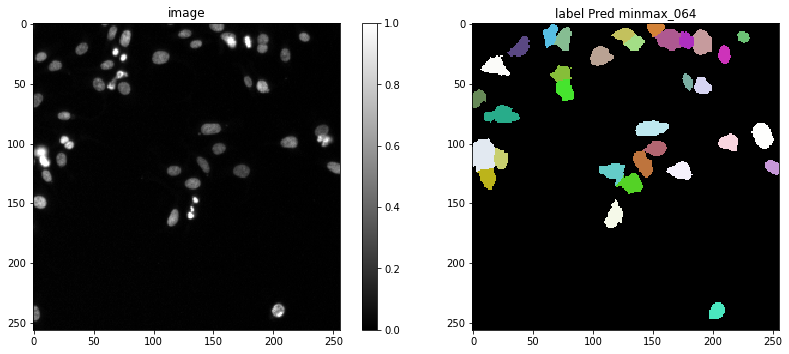

416it [00:04, 89.21it/s] 


2022-09-29 16:14:45,051 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 16:14:45,053 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 16:14:45,055 [INFO] >>>> using GPU
2022-09-29 16:14:45,313 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:10<00:00, 38.67it/s]


2022-09-29 16:14:57,175 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.33it/s]


2022-09-29 16:14:59,572 [INFO] >>>> median diameter set to = 30
2022-09-29 16:14:59,574 [INFO] >>>> mean of training label mask diameters (saved to model) 23.276
2022-09-29 16:14:59,575 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 16:14:59,576 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 16:14:59,577 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 16:14:59,578 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 16:15:07,985 [INFO] Epoch 0, Time  8.4s, Loss 5.9141, Loss Test 1.6204, LR 0.0000
2022-09-29 16:15:15,762 [INFO] saving network parameters to paper03/models/minmax_256
2022-09-29 16:15:50,507 [INFO] Epoch 5, Time 50.9s, Loss 1.4477, Loss Test 0.9646, LR 0.0006
2022-09-29 16:16:37,052 [INFO] Epoch 10, Time 97.5s, Loss 0.7345, Loss Test 1.0857, LR 0.0010
2022-09-29 16:18:09,578 [INFO] Epoch 20, Time 190.0s, Loss 0.5870, Loss Test 1.2880, LR 0.0010
2022-09-29 16:19:41,169 [INFO] Epoch 30, Time 281.6s, Loss 0.5166, Loss Test 1.4926, LR 0.0010

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.37it/s]


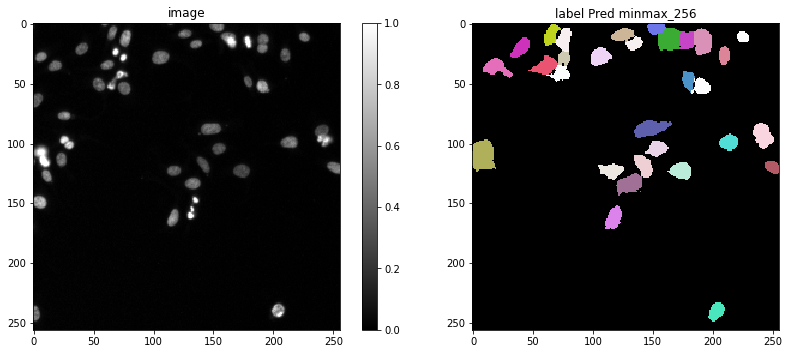

2022-09-29 16:30:21,071 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 16:30:21,073 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 16:30:21,074 [INFO] >>>> using GPU
2022-09-29 16:30:21,376 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:14<00:00, 29.61it/s]


2022-09-29 16:30:36,041 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.57it/s]


2022-09-29 16:30:38,459 [INFO] >>>> median diameter set to = 30
2022-09-29 16:30:38,460 [INFO] >>>> mean of training label mask diameters (saved to model) 23.259
2022-09-29 16:30:38,462 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 16:30:38,463 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 16:30:38,464 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 16:30:38,465 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 16:30:49,189 [INFO] Epoch 0, Time 10.7s, Loss 1.6317, Loss Test 1.6256, LR 0.0000
2022-09-29 16:30:59,654 [INFO] saving network parameters to paper03/models/minmax_full
2022-09-29 16:31:41,143 [INFO] Epoch 5, Time 62.7s, Loss 0.9367, Loss Test 0.5460, LR 0.0006
2022-09-29 16:32:32,197 [INFO] Epoch 10, Time 113.7s, Loss 0.4121, Loss Test 0.2980, LR 0.0010
2022-09-29 16:34:13,705 [INFO] Epoch 20, Time 215.2s, Loss 0.2666, Loss Test 0.2158, LR 0.0010
2022-09-29 16:35:56,100 [INFO] Epoch 30, Time 317.6s, Loss 0.2239, Loss Test 0.1988, LR 0.00

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.85it/s]


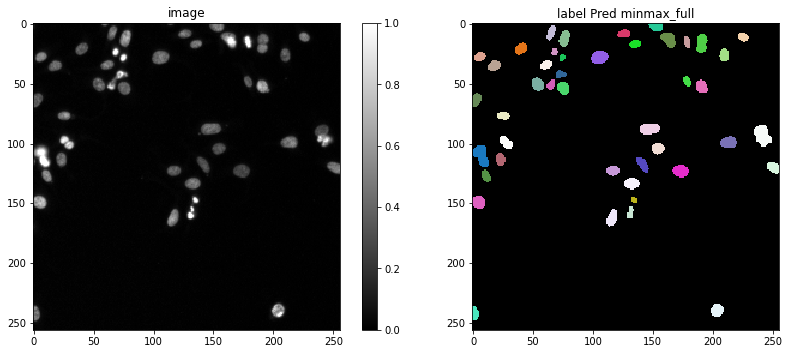

416it [00:04, 91.97it/s] 
416it [00:00, 1564.50it/s]


2022-09-29 16:47:55,975 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 16:47:55,976 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 16:47:55,977 [INFO] >>>> using GPU
2022-09-29 16:47:56,227 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:05<00:00, 74.72it/s]


2022-09-29 16:48:02,862 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.82it/s]


2022-09-29 16:48:05,142 [INFO] >>>> median diameter set to = 30
2022-09-29 16:48:05,143 [INFO] >>>> mean of training label mask diameters (saved to model) 14.897
2022-09-29 16:48:05,145 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 16:48:05,146 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 16:48:05,147 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 16:48:05,148 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 16:48:14,303 [INFO] Epoch 0, Time  9.2s, Loss 1.8209, Loss Test 1.5821, LR 0.0000
2022-09-29 16:48:22,878 [INFO] saving network parameters to paper03/models/min_001_bg
2022-09-29 16:48:57,452 [INFO] Epoch 5, Time 52.3s, Loss 0.9462, Loss Test 0.9393, LR 0.0006
2022-09-29 16:49:40,606 [INFO] Epoch 10, Time 95.5s, Loss 0.6881, Loss Test 0.6045, LR 0.0010
2022-09-29 16:51:05,740 [INFO] Epoch 20, Time 180.6s, Loss 0.5253, Loss Test 0.4719, LR 0.0010
2022-09-29 16:52:31,874 [INFO] Epoch 30, Time 266.7s, Loss 0.3721, Loss Test 0.5095, LR 0.0010

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.50it/s]


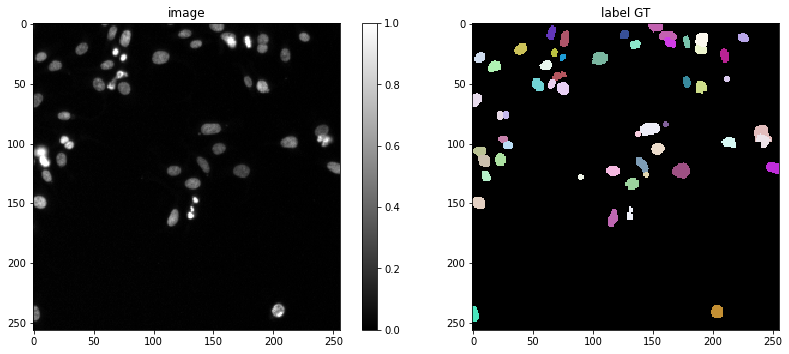

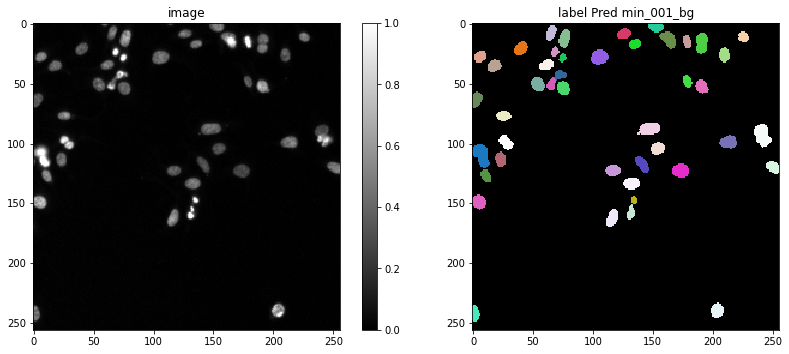

416it [00:04, 83.59it/s] 
416it [00:00, 1542.40it/s]


2022-09-29 17:02:39,290 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 17:02:39,291 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 17:02:39,292 [INFO] >>>> using GPU
2022-09-29 17:02:39,550 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:06<00:00, 60.09it/s]


2022-09-29 17:02:47,576 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.50it/s]


2022-09-29 17:02:49,931 [INFO] >>>> median diameter set to = 30
2022-09-29 17:02:49,932 [INFO] >>>> mean of training label mask diameters (saved to model) 19.793
2022-09-29 17:02:49,934 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 17:02:49,935 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 17:02:49,936 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 17:02:49,937 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 17:02:59,101 [INFO] Epoch 0, Time  9.2s, Loss 3.0260, Loss Test 1.6418, LR 0.0000
2022-09-29 17:03:07,738 [INFO] saving network parameters to paper03/models/min_004_bg
2022-09-29 17:03:39,037 [INFO] Epoch 5, Time 49.1s, Loss 1.2224, Loss Test 0.6624, LR 0.0006
2022-09-29 17:04:22,398 [INFO] Epoch 10, Time 92.5s, Loss 0.7135, Loss Test 0.4232, LR 0.0010
2022-09-29 17:05:49,744 [INFO] Epoch 20, Time 179.8s, Loss 0.6185, Loss Test 0.4114, LR 0.0010
2022-09-29 17:07:16,473 [INFO] Epoch 30, Time 266.5s, Loss 0.5396, Loss Test 0.3536, LR 0.0010

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.14it/s]


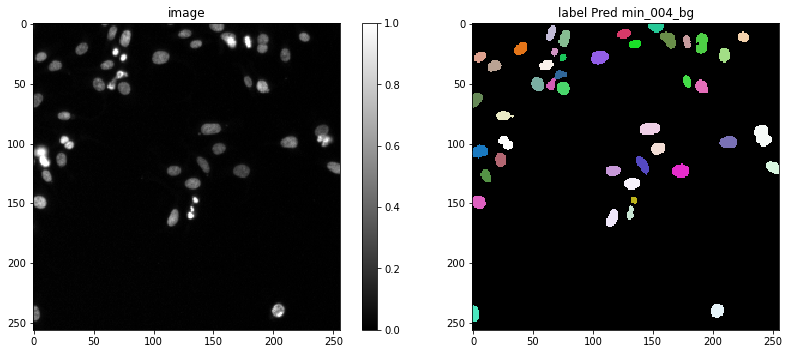

416it [00:04, 90.12it/s] 
416it [00:00, 1267.46it/s]

2022-09-29 17:17:34,892 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 17:17:34,893 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 17:17:34,894 [INFO] >>>> using GPU


2022-09-29 17:17:35,148 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:10<00:00, 40.76it/s]


2022-09-29 17:17:46,467 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.46it/s]


2022-09-29 17:17:49,243 [INFO] >>>> median diameter set to = 30
2022-09-29 17:17:49,244 [INFO] >>>> mean of training label mask diameters (saved to model) 22.620
2022-09-29 17:17:49,246 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 17:17:49,247 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 17:17:49,248 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 17:17:49,249 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 17:17:58,734 [INFO] Epoch 0, Time  9.5s, Loss 3.4647, Loss Test 1.4885, LR 0.0000
2022-09-29 17:18:07,586 [INFO] saving network parameters to paper03/models/min_016_bg
2022-09-29 17:18:43,216 [INFO] Epoch 5, Time 54.0s, Loss 1.3094, Loss Test 0.6767, LR 0.0006
2022-09-29 17:19:27,851 [INFO] Epoch 10, Time 98.6s, Loss 0.7672, Loss Test 0.4483, LR 0.0010
2022-09-29 17:20:56,780 [INFO] Epoch 20, Time 187.5s, Loss 0.6414, Loss Test 0.4633, LR 0.0010
2022-09-29 17:22:26,263 [INFO] Epoch 30, Time 277.0s, Loss 0.5864, Loss Test 0.3945, LR 0.0010

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.89it/s]


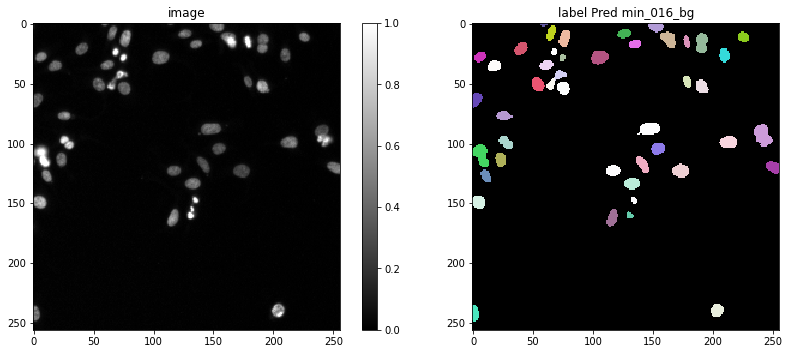

416it [00:05, 81.54it/s] 
416it [00:00, 1316.11it/s]

2022-09-29 17:32:50,364 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 17:32:50,366 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 17:32:50,366 [INFO] >>>> using GPU


2022-09-29 17:32:50,619 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:08<00:00, 46.29it/s]


2022-09-29 17:33:00,749 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.54it/s]


2022-09-29 17:33:03,076 [INFO] >>>> median diameter set to = 30
2022-09-29 17:33:03,078 [INFO] >>>> mean of training label mask diameters (saved to model) 22.575
2022-09-29 17:33:03,079 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 17:33:03,080 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 17:33:03,081 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 17:33:03,082 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 17:33:12,407 [INFO] Epoch 0, Time  9.3s, Loss 3.6150, Loss Test 1.6635, LR 0.0000
2022-09-29 17:33:21,201 [INFO] saving network parameters to paper03/models/min_064_bg
2022-09-29 17:33:57,441 [INFO] Epoch 5, Time 54.4s, Loss 1.4110, Loss Test 0.6807, LR 0.0006
2022-09-29 17:34:41,325 [INFO] Epoch 10, Time 98.2s, Loss 0.7878, Loss Test 0.4738, LR 0.0010
2022-09-29 17:36:08,698 [INFO] Epoch 20, Time 185.6s, Loss 0.6450, Loss Test 0.4760, LR 0.0010
2022-09-29 17:37:36,781 [INFO] Epoch 30, Time 273.7s, Loss 0.5826, Loss Test 0.4521, LR 0.0010

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.03it/s]


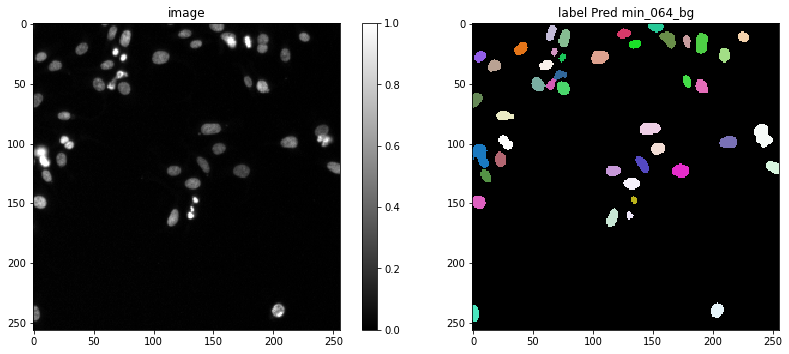

416it [00:05, 74.52it/s]
416it [00:00, 1185.47it/s]

2022-09-29 17:48:01,989 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 17:48:01,990 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 17:48:01,991 [INFO] >>>> using GPU


2022-09-29 17:48:02,246 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:09<00:00, 41.80it/s]


2022-09-29 17:48:13,261 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 35.57it/s]


2022-09-29 17:48:15,516 [INFO] >>>> median diameter set to = 30
2022-09-29 17:48:15,518 [INFO] >>>> mean of training label mask diameters (saved to model) 22.573
2022-09-29 17:48:15,519 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 17:48:15,521 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 17:48:15,521 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 17:48:15,522 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 17:48:24,992 [INFO] Epoch 0, Time  9.5s, Loss 3.4996, Loss Test 1.5463, LR 0.0000
2022-09-29 17:48:34,022 [INFO] saving network parameters to paper03/models/min_256_bg
2022-09-29 17:49:10,327 [INFO] Epoch 5, Time 54.8s, Loss 1.3148, Loss Test 0.7034, LR 0.0006
2022-09-29 17:49:56,533 [INFO] Epoch 10, Time 101.0s, Loss 0.7754, Loss Test 0.5041, LR 0.0010
2022-09-29 17:51:26,464 [INFO] Epoch 20, Time 190.9s, Loss 0.6443, Loss Test 0.4891, LR 0.0010
2022-09-29 17:52:55,320 [INFO] Epoch 30, Time 279.8s, Loss 0.5822, Loss Test 0.4357, LR 0.001

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.86it/s]


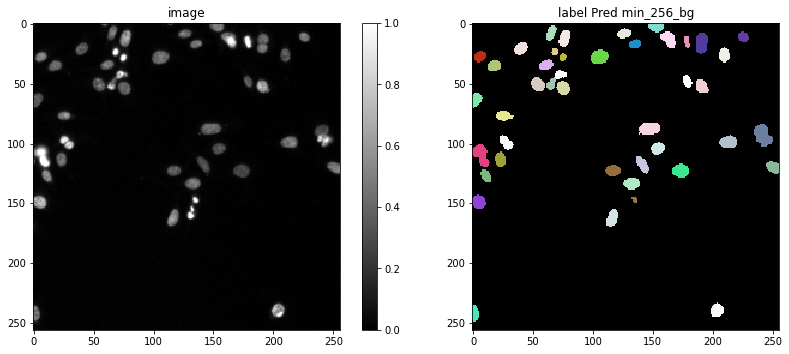

2022-09-29 18:03:27,971 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 18:03:27,973 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 18:03:27,974 [INFO] >>>> using GPU
2022-09-29 18:03:28,448 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:12<00:00, 33.12it/s]


2022-09-29 18:03:41,705 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 30.64it/s]


2022-09-29 18:03:44,292 [INFO] >>>> median diameter set to = 30
2022-09-29 18:03:44,294 [INFO] >>>> mean of training label mask diameters (saved to model) 23.259
2022-09-29 18:03:44,295 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 18:03:44,296 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 18:03:44,297 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 18:03:44,298 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 18:03:55,683 [INFO] Epoch 0, Time 11.4s, Loss 1.6958, Loss Test 1.6831, LR 0.0000
2022-09-29 18:04:05,897 [INFO] saving network parameters to paper03/models/min_full_bg
2022-09-29 18:04:48,989 [INFO] Epoch 5, Time 64.7s, Loss 0.8809, Loss Test 0.5277, LR 0.0006
2022-09-29 18:05:41,259 [INFO] Epoch 10, Time 117.0s, Loss 0.4034, Loss Test 0.2921, LR 0.0010
2022-09-29 18:07:24,483 [INFO] Epoch 20, Time 220.2s, Loss 0.2653, Loss Test 0.2191, LR 0.0010
2022-09-29 18:09:09,634 [INFO] Epoch 30, Time 325.3s, Loss 0.2249, Loss Test 0.1980, LR 0.00

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.60it/s]


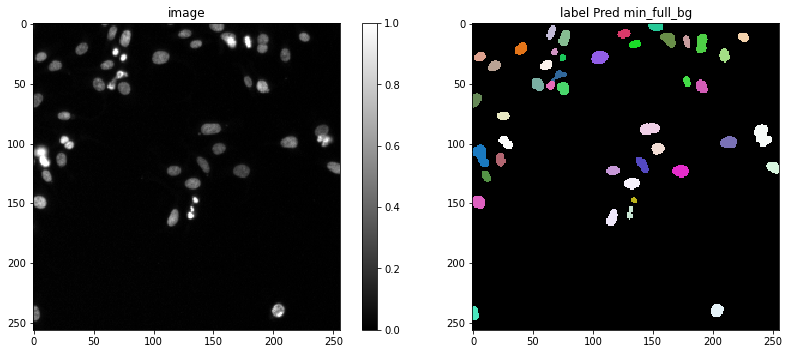

416it [00:04, 91.94it/s] 
416it [00:00, 1510.21it/s]


2022-09-29 18:20:51,632 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 18:20:51,634 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 18:20:51,635 [INFO] >>>> using GPU
2022-09-29 18:20:51,886 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:06<00:00, 62.62it/s]


2022-09-29 18:20:59,672 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 31.24it/s]


2022-09-29 18:21:02,136 [INFO] >>>> median diameter set to = 30
2022-09-29 18:21:02,137 [INFO] >>>> mean of training label mask diameters (saved to model) 21.360
2022-09-29 18:21:02,139 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 18:21:02,140 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 18:21:02,141 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 18:21:02,142 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 18:21:11,125 [INFO] Epoch 0, Time  9.0s, Loss 1.7469, Loss Test 1.5917, LR 0.0000
2022-09-29 18:21:19,130 [INFO] saving network parameters to paper03/models/max_001_bg
2022-09-29 18:22:51,275 [INFO] Epoch 5, Time 109.1s, Loss 0.6272, Loss Test 1.0325, LR 0.0006
2022-09-29 18:23:34,483 [INFO] Epoch 10, Time 152.3s, Loss 0.4235, Loss Test 0.7853, LR 0.0010
2022-09-29 18:25:00,364 [INFO] Epoch 20, Time 238.2s, Loss 0.2981, Loss Test 0.6944, LR 0.0010
2022-09-29 18:26:24,855 [INFO] Epoch 30, Time 322.7s, Loss 0.2875, Loss Test 0.5441, LR 0.00

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.13it/s]


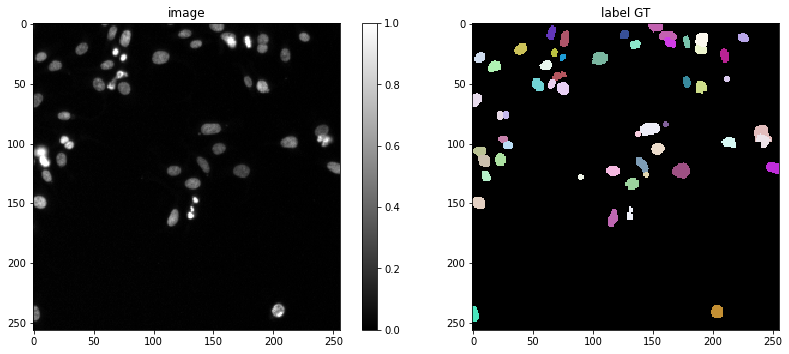

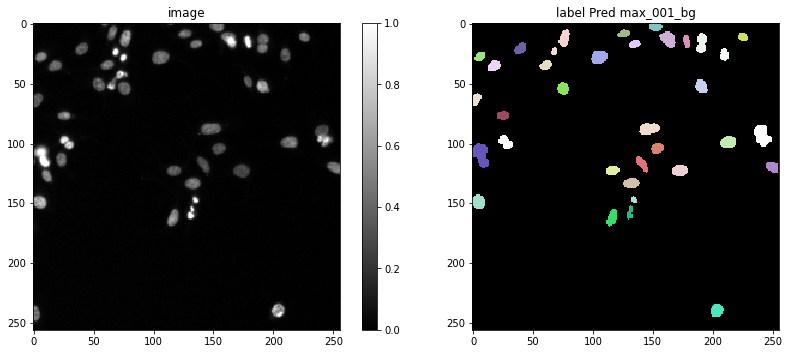

416it [00:05, 72.35it/s]
416it [00:00, 1347.37it/s]

2022-09-29 18:36:43,873 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 18:36:43,875 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 18:36:43,876 [INFO] >>>> using GPU


2022-09-29 18:36:44,140 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:10<00:00, 39.94it/s]


2022-09-29 18:36:56,023 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 22.85it/s]


2022-09-29 18:36:59,500 [INFO] >>>> median diameter set to = 30
2022-09-29 18:36:59,501 [INFO] >>>> mean of training label mask diameters (saved to model) 22.236
2022-09-29 18:36:59,504 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 18:36:59,505 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 18:36:59,506 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 18:36:59,507 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 18:37:09,843 [INFO] Epoch 0, Time 10.3s, Loss 2.9348, Loss Test 1.5066, LR 0.0000
2022-09-29 18:37:18,918 [INFO] saving network parameters to paper03/models/max_004_bg
2022-09-29 18:37:56,252 [INFO] Epoch 5, Time 56.7s, Loss 1.0192, Loss Test 0.7559, LR 0.0006
2022-09-29 18:38:41,703 [INFO] Epoch 10, Time 102.2s, Loss 0.6221, Loss Test 0.5191, LR 0.0010
2022-09-29 18:40:13,153 [INFO] Epoch 20, Time 193.6s, Loss 0.5018, Loss Test 0.4539, LR 0.0010
2022-09-29 18:41:43,805 [INFO] Epoch 30, Time 284.3s, Loss 0.4119, Loss Test 0.4343, LR 0.001

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.82it/s]


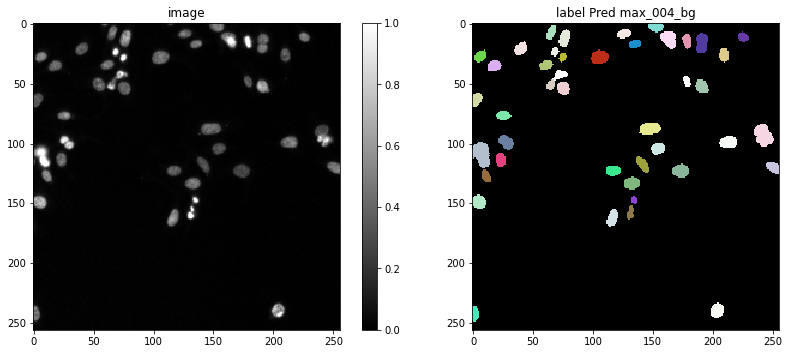

416it [00:05, 78.70it/s]
416it [00:00, 1255.77it/s]

2022-09-29 18:52:11,817 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 18:52:11,818 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 18:52:11,819 [INFO] >>>> using GPU


2022-09-29 18:52:12,072 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:08<00:00, 48.54it/s]


2022-09-29 18:52:21,803 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.46it/s]


2022-09-29 18:52:24,224 [INFO] >>>> median diameter set to = 30
2022-09-29 18:52:24,225 [INFO] >>>> mean of training label mask diameters (saved to model) 23.018
2022-09-29 18:52:24,227 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 18:52:24,228 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 18:52:24,229 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 18:52:24,229 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 18:52:33,630 [INFO] Epoch 0, Time  9.4s, Loss 3.4908, Loss Test 1.5811, LR 0.0000
2022-09-29 18:52:42,140 [INFO] saving network parameters to paper03/models/max_016_bg
2022-09-29 18:53:18,108 [INFO] Epoch 5, Time 53.9s, Loss 1.3505, Loss Test 0.7728, LR 0.0006
2022-09-29 18:54:03,359 [INFO] Epoch 10, Time 99.1s, Loss 0.7773, Loss Test 0.5859, LR 0.0010
2022-09-29 18:55:33,686 [INFO] Epoch 20, Time 189.5s, Loss 0.6033, Loss Test 0.4981, LR 0.0010
2022-09-29 18:57:03,142 [INFO] Epoch 30, Time 278.9s, Loss 0.5294, Loss Test 0.4641, LR 0.0010

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.37it/s]


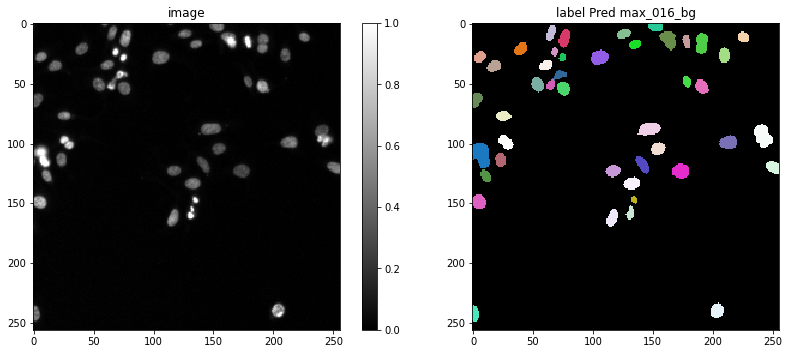

416it [00:04, 93.31it/s] 
416it [00:00, 1284.72it/s]

2022-09-29 19:07:31,201 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 19:07:31,202 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 19:07:31,203 [INFO] >>>> using GPU


2022-09-29 19:07:31,461 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:09<00:00, 41.79it/s]


2022-09-29 19:07:42,501 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 31.42it/s]


2022-09-29 19:07:44,992 [INFO] >>>> median diameter set to = 30
2022-09-29 19:07:44,993 [INFO] >>>> mean of training label mask diameters (saved to model) 23.041
2022-09-29 19:07:44,995 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 19:07:44,996 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 19:07:44,996 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 19:07:44,997 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 19:07:54,137 [INFO] Epoch 0, Time  9.1s, Loss 3.6584, Loss Test 1.6291, LR 0.0000
2022-09-29 19:08:03,045 [INFO] saving network parameters to paper03/models/max_064_bg
2022-09-29 19:08:39,412 [INFO] Epoch 5, Time 54.4s, Loss 1.4011, Loss Test 0.7796, LR 0.0006
2022-09-29 19:09:24,010 [INFO] Epoch 10, Time 99.0s, Loss 0.7733, Loss Test 0.6043, LR 0.0010
2022-09-29 19:10:53,023 [INFO] Epoch 20, Time 188.0s, Loss 0.6144, Loss Test 0.4730, LR 0.0010
2022-09-29 19:12:21,848 [INFO] Epoch 30, Time 276.9s, Loss 0.5378, Loss Test 0.3929, LR 0.0010

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.45it/s]


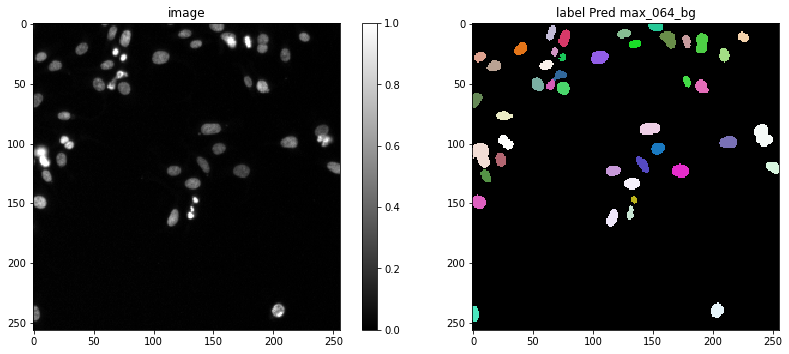

416it [00:04, 93.48it/s] 
416it [00:00, 1261.66it/s]

2022-09-29 19:22:46,870 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 19:22:46,871 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 19:22:46,872 [INFO] >>>> using GPU


2022-09-29 19:22:47,125 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:08<00:00, 49.67it/s]


2022-09-29 19:22:56,937 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 26.42it/s]


2022-09-29 19:22:59,663 [INFO] >>>> median diameter set to = 30
2022-09-29 19:22:59,664 [INFO] >>>> mean of training label mask diameters (saved to model) 23.044
2022-09-29 19:22:59,666 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 19:22:59,667 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 19:22:59,667 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 19:22:59,668 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 19:23:09,068 [INFO] Epoch 0, Time  9.4s, Loss 3.8356, Loss Test 1.5013, LR 0.0000
2022-09-29 19:23:18,026 [INFO] saving network parameters to paper03/models/max_256_bg
2022-09-29 19:23:54,254 [INFO] Epoch 5, Time 54.6s, Loss 1.2860, Loss Test 0.6559, LR 0.0006
2022-09-29 19:24:39,070 [INFO] Epoch 10, Time 99.4s, Loss 0.7469, Loss Test 0.4545, LR 0.0010
2022-09-29 19:26:07,676 [INFO] Epoch 20, Time 188.0s, Loss 0.6076, Loss Test 0.4528, LR 0.0010
2022-09-29 19:27:37,074 [INFO] Epoch 30, Time 277.4s, Loss 0.5397, Loss Test 0.4231, LR 0.0010

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.07it/s]


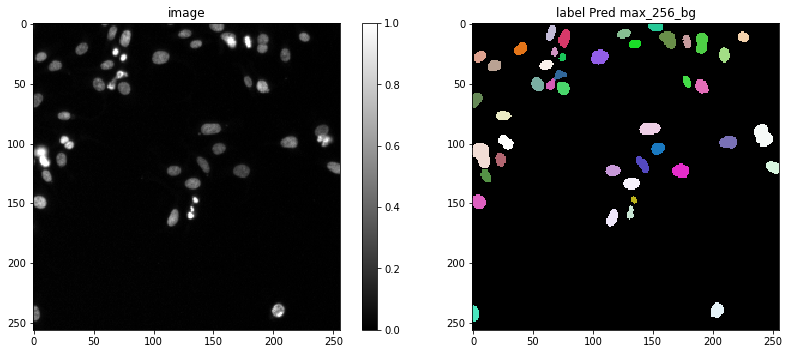

2022-09-29 19:37:59,710 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 19:37:59,712 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 19:37:59,713 [INFO] >>>> using GPU
2022-09-29 19:38:00,025 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:10<00:00, 38.88it/s]


2022-09-29 19:38:11,341 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.75it/s]


2022-09-29 19:38:13,655 [INFO] >>>> median diameter set to = 30
2022-09-29 19:38:13,656 [INFO] >>>> mean of training label mask diameters (saved to model) 23.259
2022-09-29 19:38:13,658 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 19:38:13,659 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 19:38:13,660 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 19:38:13,661 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 19:38:24,015 [INFO] Epoch 0, Time 10.4s, Loss 1.5820, Loss Test 1.5786, LR 0.0000
2022-09-29 19:38:33,773 [INFO] saving network parameters to paper03/models/max_full_bg
2022-09-29 19:39:14,467 [INFO] Epoch 5, Time 60.8s, Loss 0.9029, Loss Test 0.5219, LR 0.0006
2022-09-29 19:40:04,871 [INFO] Epoch 10, Time 111.2s, Loss 0.3906, Loss Test 0.2855, LR 0.0010
2022-09-29 19:41:45,857 [INFO] Epoch 20, Time 212.2s, Loss 0.2604, Loss Test 0.2192, LR 0.0010
2022-09-29 19:43:26,040 [INFO] Epoch 30, Time 312.4s, Loss 0.2215, Loss Test 0.1989, LR 0.00

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  5.06it/s]


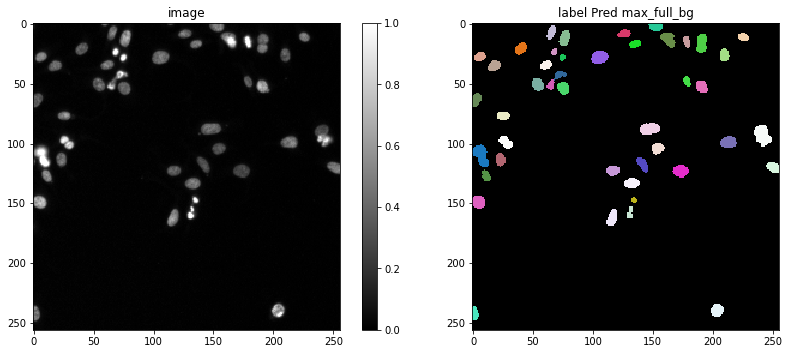

416it [00:04, 103.78it/s]
416it [00:00, 1593.45it/s]


2022-09-29 19:55:02,282 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 19:55:02,283 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 19:55:02,284 [INFO] >>>> using GPU
2022-09-29 19:55:02,528 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:05<00:00, 80.29it/s]


2022-09-29 19:55:08,798 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 35.45it/s]


2022-09-29 19:55:10,992 [INFO] >>>> median diameter set to = 30
2022-09-29 19:55:10,994 [INFO] >>>> mean of training label mask diameters (saved to model) 17.034
2022-09-29 19:55:10,995 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 19:55:10,996 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 19:55:10,997 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 19:55:10,998 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 19:55:19,848 [INFO] Epoch 0, Time  8.9s, Loss 2.5686, Loss Test 1.8164, LR 0.0000
2022-09-29 19:55:28,175 [INFO] saving network parameters to paper03/models/minmax_001_bg
2022-09-29 19:56:02,494 [INFO] Epoch 5, Time 51.5s, Loss 1.1004, Loss Test 1.1385, LR 0.0006
2022-09-29 19:56:45,506 [INFO] Epoch 10, Time 94.5s, Loss 0.7391, Loss Test 0.6997, LR 0.0010
2022-09-29 19:58:10,328 [INFO] Epoch 20, Time 179.3s, Loss 0.5871, Loss Test 0.5567, LR 0.0010
2022-09-29 19:59:34,911 [INFO] Epoch 30, Time 263.9s, Loss 0.4616, Loss Test 0.4697, LR 0.0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.66it/s]


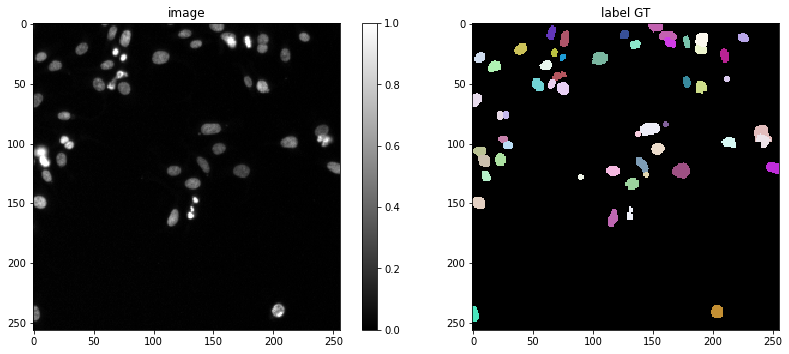

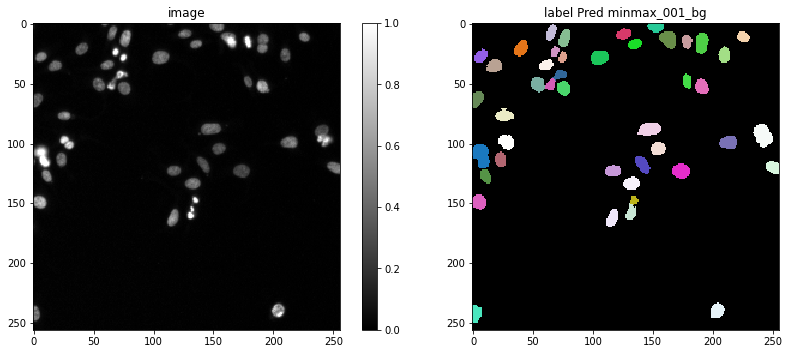

416it [00:04, 85.40it/s] 
416it [00:00, 1558.26it/s]


2022-09-29 20:09:38,222 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 20:09:38,223 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 20:09:38,224 [INFO] >>>> using GPU
2022-09-29 20:09:38,475 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:06<00:00, 60.87it/s]


2022-09-29 20:09:46,372 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 35.23it/s]


2022-09-29 20:09:48,590 [INFO] >>>> median diameter set to = 30
2022-09-29 20:09:48,591 [INFO] >>>> mean of training label mask diameters (saved to model) 19.633
2022-09-29 20:09:48,593 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 20:09:48,593 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 20:09:48,594 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 20:09:48,595 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 20:09:57,233 [INFO] Epoch 0, Time  8.6s, Loss 3.1804, Loss Test 1.5772, LR 0.0000
2022-09-29 20:10:05,809 [INFO] saving network parameters to paper03/models/minmax_004_bg
2022-09-29 20:10:40,728 [INFO] Epoch 5, Time 52.1s, Loss 1.2479, Loss Test 0.7690, LR 0.0006
2022-09-29 20:11:23,927 [INFO] Epoch 10, Time 95.3s, Loss 0.7434, Loss Test 0.5382, LR 0.0010
2022-09-29 20:12:50,003 [INFO] Epoch 20, Time 181.4s, Loss 0.5671, Loss Test 0.5280, LR 0.0010
2022-09-29 20:14:09,836 [INFO] Epoch 30, Time 261.2s, Loss 0.5082, Loss Test 0.3876, LR 0.0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.03it/s]


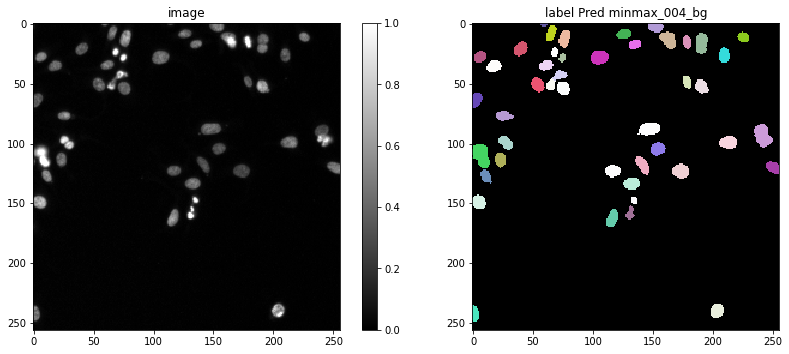

416it [00:04, 94.54it/s] 
416it [00:00, 1216.95it/s]

2022-09-29 20:24:23,766 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 20:24:23,767 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 20:24:23,769 [INFO] >>>> using GPU


2022-09-29 20:24:24,016 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:08<00:00, 46.89it/s]


2022-09-29 20:24:34,322 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 26.61it/s]


2022-09-29 20:24:37,018 [INFO] >>>> median diameter set to = 30
2022-09-29 20:24:37,019 [INFO] >>>> mean of training label mask diameters (saved to model) 22.935
2022-09-29 20:24:37,021 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 20:24:37,022 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 20:24:37,023 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 20:24:37,024 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 20:24:46,565 [INFO] Epoch 0, Time  9.5s, Loss 3.8639, Loss Test 1.4713, LR 0.0000
2022-09-29 20:24:55,460 [INFO] saving network parameters to paper03/models/minmax_016_bg
2022-09-29 20:25:31,573 [INFO] Epoch 5, Time 54.5s, Loss 1.4270, Loss Test 0.6507, LR 0.0006
2022-09-29 20:26:16,577 [INFO] Epoch 10, Time 99.6s, Loss 0.7852, Loss Test 0.4295, LR 0.0010
2022-09-29 20:27:45,455 [INFO] Epoch 20, Time 188.4s, Loss 0.6415, Loss Test 0.4335, LR 0.0010
2022-09-29 20:29:13,884 [INFO] Epoch 30, Time 276.9s, Loss 0.5673, Loss Test 0.3921, LR 0.0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.58it/s]


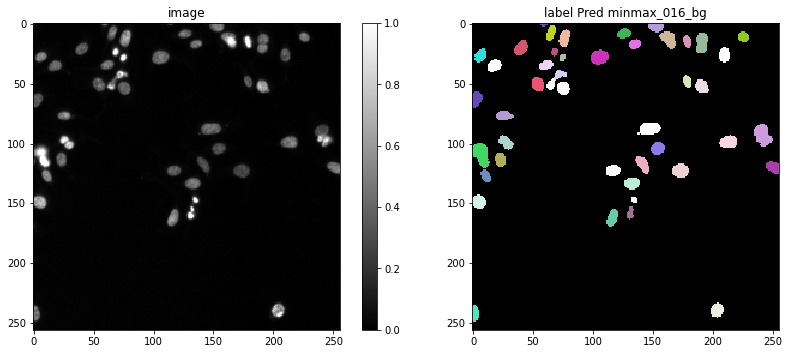

416it [00:04, 88.40it/s] 
416it [00:00, 1100.77it/s]


2022-09-29 20:39:40,213 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 20:39:40,214 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 20:39:40,215 [INFO] >>>> using GPU
2022-09-29 20:39:40,474 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:10<00:00, 38.98it/s]


2022-09-29 20:39:52,205 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.39it/s]


2022-09-29 20:39:54,543 [INFO] >>>> median diameter set to = 30
2022-09-29 20:39:54,545 [INFO] >>>> mean of training label mask diameters (saved to model) 23.283
2022-09-29 20:39:54,546 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 20:39:54,547 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 20:39:54,548 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 20:39:54,549 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 20:40:04,070 [INFO] Epoch 0, Time  9.5s, Loss 4.1932, Loss Test 1.5267, LR 0.0000
2022-09-29 20:40:12,891 [INFO] saving network parameters to paper03/models/minmax_064_bg
2022-09-29 20:40:49,528 [INFO] Epoch 5, Time 55.0s, Loss 1.3969, Loss Test 0.6106, LR 0.0006
2022-09-29 20:41:35,277 [INFO] Epoch 10, Time 100.7s, Loss 0.8099, Loss Test 0.4651, LR 0.0010
2022-09-29 20:43:05,600 [INFO] Epoch 20, Time 191.1s, Loss 0.6479, Loss Test 0.4417, LR 0.0010
2022-09-29 20:44:35,494 [INFO] Epoch 30, Time 280.9s, Loss 0.5848, Loss Test 0.3861, LR 0.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.13it/s]


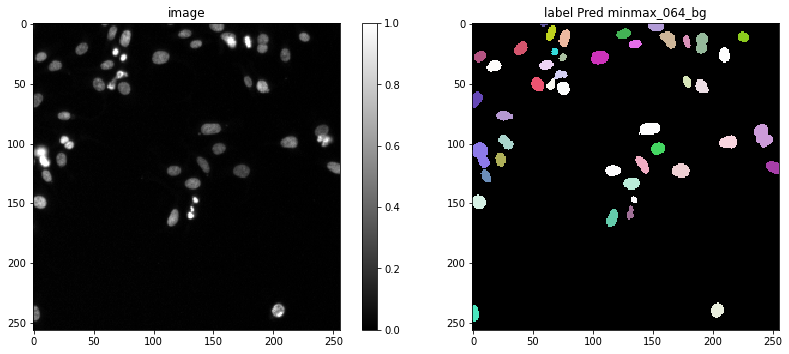

416it [00:04, 91.57it/s] 
416it [00:00, 1125.16it/s]

2022-09-29 20:55:16,372 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 20:55:16,374 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 20:55:16,375 [INFO] >>>> using GPU


2022-09-29 20:55:16,618 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:10<00:00, 39.92it/s]


2022-09-29 20:55:28,072 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 35.14it/s]


2022-09-29 20:55:30,352 [INFO] >>>> median diameter set to = 30
2022-09-29 20:55:30,353 [INFO] >>>> mean of training label mask diameters (saved to model) 23.276
2022-09-29 20:55:30,355 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 20:55:30,356 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 20:55:30,357 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 20:55:30,358 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 20:55:39,905 [INFO] Epoch 0, Time  9.5s, Loss 3.9465, Loss Test 1.6618, LR 0.0000
2022-09-29 20:55:48,953 [INFO] saving network parameters to paper03/models/minmax_256_bg
2022-09-29 20:56:25,843 [INFO] Epoch 5, Time 55.5s, Loss 1.4876, Loss Test 0.6956, LR 0.0006
2022-09-29 20:57:06,716 [INFO] Epoch 10, Time 96.4s, Loss 0.8192, Loss Test 0.4711, LR 0.0010
2022-09-29 20:58:32,874 [INFO] Epoch 20, Time 182.5s, Loss 0.6568, Loss Test 0.4468, LR 0.0010
2022-09-29 21:00:03,536 [INFO] Epoch 30, Time 273.2s, Loss 0.5907, Loss Test 0.4216, LR 0.0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.40it/s]


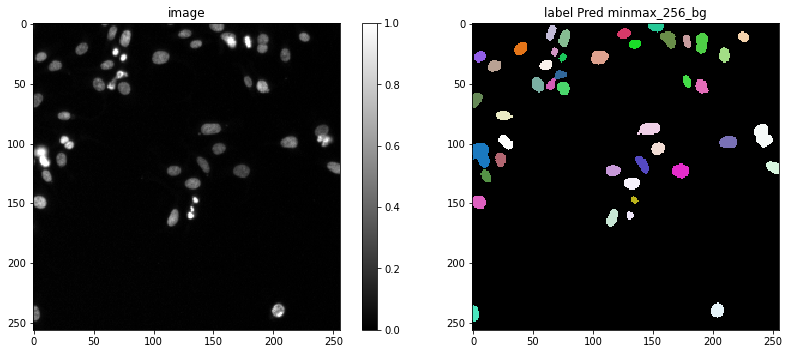

2022-09-29 21:10:41,974 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 21:10:41,976 [INFO] ** TORCH CUDA version installed and working. **
2022-09-29 21:10:41,977 [INFO] >>>> using GPU
2022-09-29 21:10:42,289 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:10<00:00, 39.59it/s]


2022-09-29 21:10:53,397 [INFO] computing flows for labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 35.19it/s]


2022-09-29 21:10:55,678 [INFO] >>>> median diameter set to = 30
2022-09-29 21:10:55,679 [INFO] >>>> mean of training label mask diameters (saved to model) 23.259
2022-09-29 21:10:55,681 [INFO] >>>> training network with 2 channel input <<<<
2022-09-29 21:10:55,682 [INFO] >>>> LR: 0.00100, batch_size: 8, weight_decay: 0.00010
2022-09-29 21:10:55,682 [INFO] >>>> ntrain = 416, ntest = 48
2022-09-29 21:10:55,683 [INFO] >>>> nimg_per_epoch = 416
2022-09-29 21:11:06,043 [INFO] Epoch 0, Time 10.4s, Loss 1.4406, Loss Test 1.4607, LR 0.0000
2022-09-29 21:11:16,001 [INFO] saving network parameters to paper03/models/minmax_full_bg
2022-09-29 21:11:56,600 [INFO] Epoch 5, Time 60.9s, Loss 0.8086, Loss Test 0.4914, LR 0.0006
2022-09-29 21:12:46,643 [INFO] Epoch 10, Time 111.0s, Loss 0.3843, Loss Test 0.2873, LR 0.0010
2022-09-29 21:14:26,567 [INFO] Epoch 20, Time 210.9s, Loss 0.2643, Loss Test 0.2156, LR 0.0010
2022-09-29 21:16:06,377 [INFO] Epoch 30, Time 310.7s, Loss 0.2252, Loss Test 0.1983, LR 0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  5.10it/s]


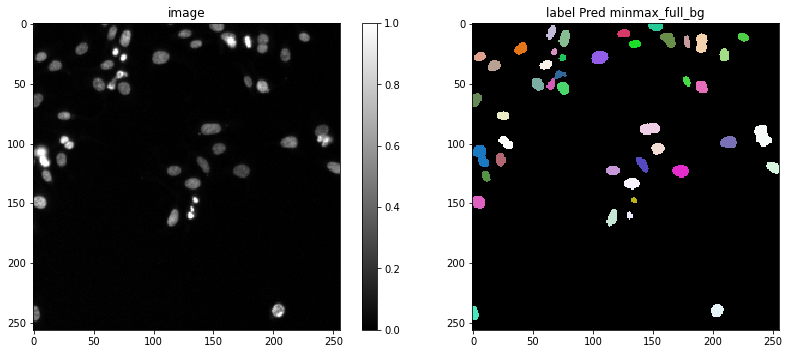

In [12]:
stats_list_dict = {}
for include_bg in (False, True):
    for mode in ('min', 'max', 'minmax'):
        key = f'{mode}{"_bg" if include_bg else ""}'
        stats_list_dict[key] = run_analysis(
            X_trn,
            Y_trn,
            X_val,
            Y_val,
            train_model,
            eval_model,
            mode=mode,
            is_train=is_train,
            include_bg=include_bg,
            n_epochs=100,
            save_path='paper03',
        )

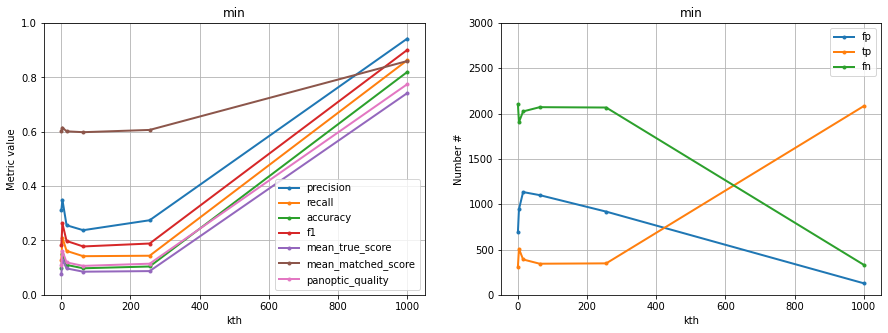

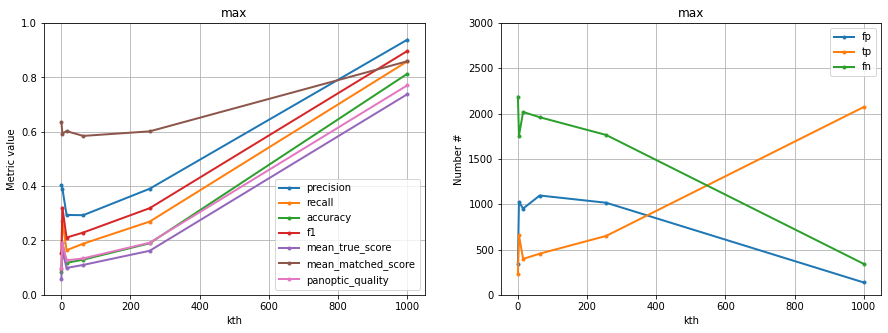

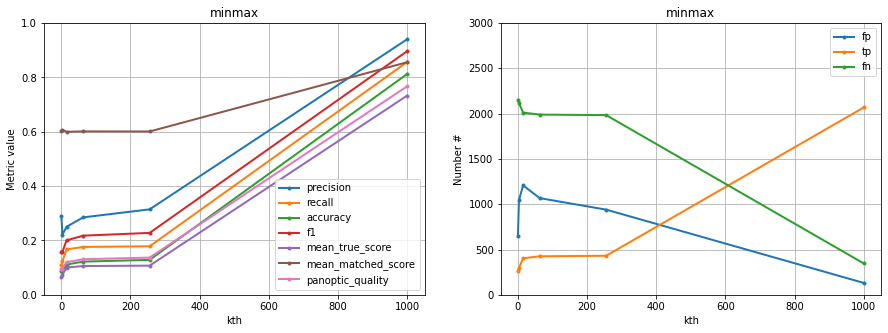

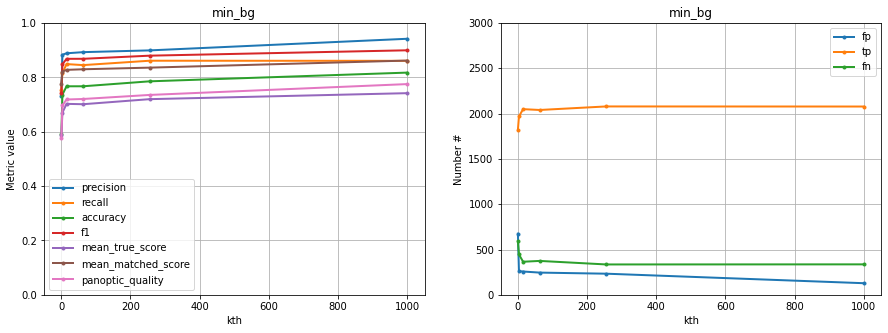

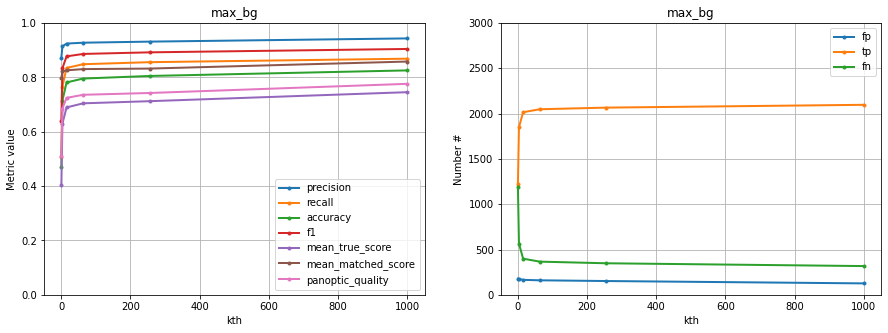

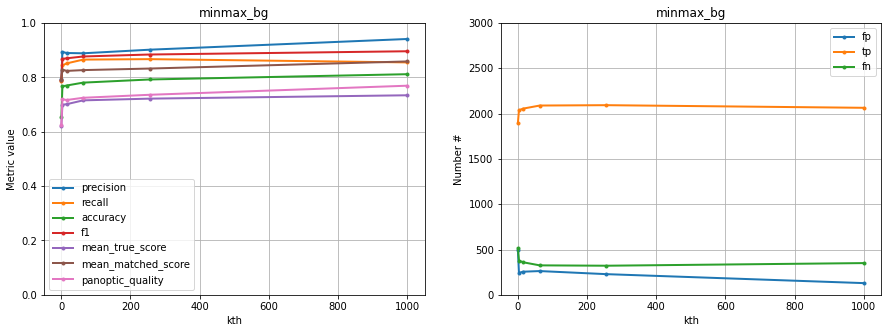

In [10]:
for include_bg in (False, True):
    for mode in ('min', 'max', 'minmax'):
        key = f'{mode}{"_bg" if include_bg else ""}'
        plot_stats(stats_list_dict[key], key)